# Boston Housing Dataset

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from cohortshapley import dataset
from cohortshapley import realistic
from cohortshapley import sampling
from cohortshapley import similarity
from cohortshapley import baselineshapley as bs
from cohortshapley import cohortshapley as cs
from cohortshapley import similarity
from cohortshapley import figure
from cohortshapley import varianceshapley as vs

In [2]:
X,Y,categorical = dataset.boston_housing()

## Train XGBoost model

In [3]:
import xgboost
def simple_xgboost_prediction(X,Y):
    model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=Y), 100)
    f = lambda x: model.predict(xgboost.DMatrix(x, feature_names=X.columns))
    return model, f

In [4]:
model, f = simple_xgboost_prediction(X,Y)

## Variance Shapley (Shapley effects) for global importance

In [5]:
similarity.bins = 10
vs_values = vs.VarianceShapley(f(X.values),similarity.binning(X.values)[0])
order=np.argsort(vs_values)[::-1]

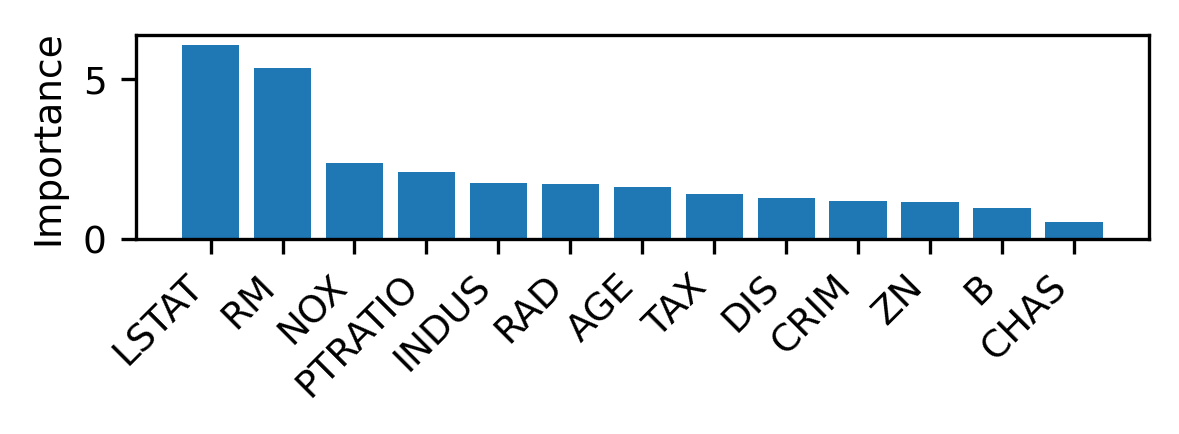

In [6]:
fig=plt.figure(figsize=(4, 1.5),dpi=300)
plt.rcParams["font.size"] = 9
plt.bar(X.columns[order],vs_values[order])
plt.ylabel('Importance')
fig.autofmt_xdate(rotation=45)
plt.tight_layout()
plt.show()

## Cohort Shapley and Baseline Shapley for local explanation

In [7]:
# subject and baseline
subject = X.values
subject_id = [204]
baseline = np.array([X.values.mean(axis=0)])

In [8]:
# compute cohort and baseline Shapley
similarity.ratio = 0.1
cs_obj = cs.CohortShapley(f, similarity.similar_in_distance_cutoff, subject_id, subject)
cs_obj.compute_cohort_shapley()

similarity.ratio=0.2
bs_obj = bs.BaselineShapley(f, subject, baseline, subject_id = subject_id, eval_realistic=True, 
                            similarity = similarity.similar_in_distance, data=subject)
bs_obj.compute_baseline_shapley()

use given model to predict y.


100%|██████████| 1/1 [01:02<00:00, 62.46s/it]


In [9]:
# create result directory and save (& load)
import os
if not os.path.isdir('result'):
    os.mkdir("result")

prefix = 'result/boston'

cs_obj.save(prefix+'_cs01')
cs_obj.load(prefix+'_cs01')

bs_obj.save(prefix+'_bsmean')
bs_obj.load(prefix+'_bsmean')

## Comparison of cohort and baseline Shapley values for 205th subject

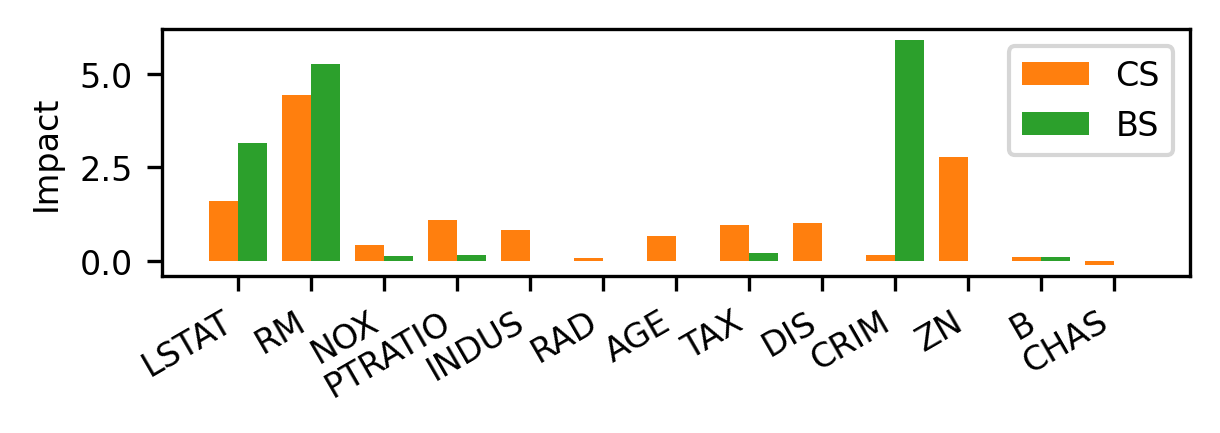

In [10]:
figure.set_color_palette('tab10')
fig=plt.figure(figsize=(4,1.5),dpi=300)
plt.rcParams["font.size"] = 8
plt.bar(np.arange(len(X.columns)),np.zeros(len(X.columns)),width=0)
plt.bar(np.arange(len(X.columns))-0.2,cs_obj.shapley_values[0][order],width=0.4,label='CS')
plt.bar(np.arange(len(X.columns))+0.2,bs_obj.shapley_values[0][order],width=0.4,label='BS')
plt.bar(np.arange(len(X.columns)),np.zeros(len(X.columns)),width=0,tick_label=X.columns[order])
plt.ylabel('Impact')
plt.axis('on')
fig.autofmt_xdate(rotation=30)
plt.legend()
plt.tight_layout()

## Scatter plots

In [11]:
# calculate synthetic data points
data = X.values
n_features = subject.shape[-1]

baselineX = pd.DataFrame(np.reshape(baseline, (1,-1)), columns=X.columns)
subjectX = pd.DataFrame(np.reshape(subject[subject_id], (1,-1)), columns=X.columns)
perm = []
for i in range(n_features):
    temp = np.copy(subject[subject_id]).reshape(n_features)
    temp[i] = baseline.reshape(n_features)[i]
    perm.append(temp)
permX = pd.DataFrame(np.array(perm), columns=X.columns)
predY = f(subject)

Text(0, 0.5, 'RM')

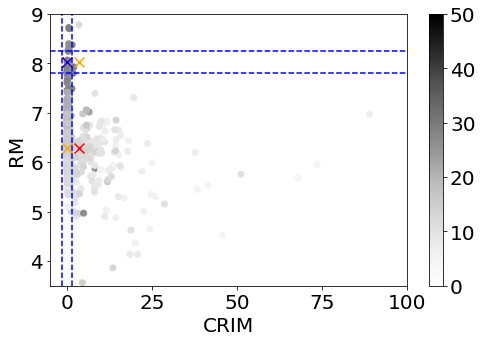

In [12]:
# plot 'CRIM' vs 'RM'
cutoff=5
xmax = pd.DataFrame([np.percentile(X.values,100-cutoff,0)],columns=X.columns)
xmin = pd.DataFrame([np.percentile(X.values,cutoff,0)],columns=X.columns)
x='CRIM'
y='RM'
plt.rcParams["font.size"] = 20
normalize = matplotlib.colors.Normalize(vmin=0, vmax=50)
plt.figure(figsize=(8,5))
plt.xlim(-5,100)
plt.ylim(3.5,9)
plt.scatter(x=X[x], y=X[y], c=predY, cmap="Greys",norm=normalize)
plt.colorbar()
plt.scatter(x=permX[x], y=permX[y], c="orange", s=100, marker='x')
plt.scatter(x=baselineX[x], y=baselineX[y], c="red", s=100, marker='x')
plt.scatter(x=subjectX[x], y=subjectX[y], c="blue", s=100, marker='x')
plt.hlines([subjectX[y]-(xmax[y]-xmin[y])/10, subjectX[y]+(xmax[y]-xmin[y])/10],-5,100,"blue", linestyles='dashed')
plt.vlines([subjectX[x]-(xmax[x]-xmin[x])/10, subjectX[x]+(xmax[x]-xmin[x])/10],3.5,9,"blue", linestyles='dashed')
plt.xlabel(x)
plt.ylabel(y)

Text(0, 0.5, 'LSTAT')

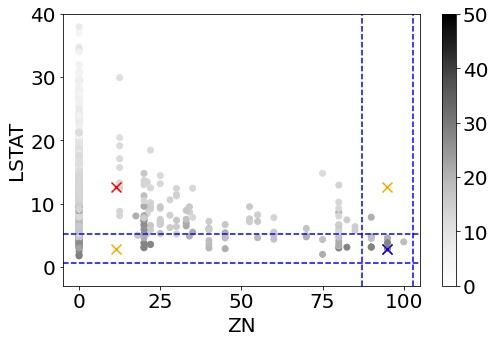

In [13]:
# Plot 'ZN' vs 'LSTAT'
cutoff=5
xmax = pd.DataFrame([np.percentile(X.values,100-cutoff,0)],columns=X.columns)
xmin = pd.DataFrame([np.percentile(X.values,cutoff,0)],columns=X.columns)
x='ZN'
y='LSTAT'
plt.rcParams["font.size"] = 20
normalize = matplotlib.colors.Normalize(vmin=0, vmax=50)
plt.figure(figsize=(8,5))
plt.xlim(-5,105)
plt.ylim(-3,40)
plt.scatter(x=X[x], y=X[y], c=predY, cmap="Greys",norm=normalize)
plt.colorbar()
plt.scatter(x=permX[x], y=permX[y], c="orange", s=100, marker='x')
plt.scatter(x=baselineX[x], y=baselineX[y], c="red", s=100, marker='x')
plt.scatter(x=subjectX[x], y=subjectX[y], c="blue", s=100, marker='x')
plt.hlines([subjectX[y]-(xmax[y]-xmin[y])/10, subjectX[y]+(xmax[y]-xmin[y])/10],-5,105,"blue", linestyles='dashed')
plt.vlines([subjectX[x]-(xmax[x]-xmin[x])/10, subjectX[x]+(xmax[x]-xmin[x])/10],-3,40,"blue", linestyles='dashed')
plt.xlabel(x)
plt.ylabel(y)

## Comparison of Cohort, baseline, and all baseline Shapley values

Computation takes very long time.

In [14]:
bs_obja = bs.BaselineShapley(f, subject, baseline)
bs_obja.compute_baseline_shapley()
bs_obja.save(prefix+'_bsmean_all')
bs_obja.load(prefix+'_bsmean_all')

similarity.ratio=0.2
abs_obj = bs.BaselineShapley(f, subject, subject, subject_id = subject_id, eval_realistic=True, 
                             similarity = similarity.similar_in_distance, data=subject)
abs_obj.compute_baseline_shapley()
abs_obj.save(prefix+'_abs')
abs_obj.load(prefix+'_abs')
    
abs_obja = bs.BaselineShapley(f, subject, subject)
abs_obja.compute_baseline_shapley()
abs_obja.save(prefix+'_abs_all')
abs_obja.load(prefix+'_abs_all')
    
cs_obja = cs.CohortShapley(f, similarity.similar_in_distance_cutoff, np.arange(len(subject)), subject)
cs_obja.compute_cohort_shapley()
cs_obja.save(prefix+'_cs01_all')
cs_obja.load(prefix+'_cs01_all')

  0%|          | 0/506 [00:00<?, ?it/s]

use given model to predict y.


100%|██████████| 506/506 [1:01:18<00:00,  7.27s/it]


### Aggregated Shapley values in stacked bar plots for all subjects

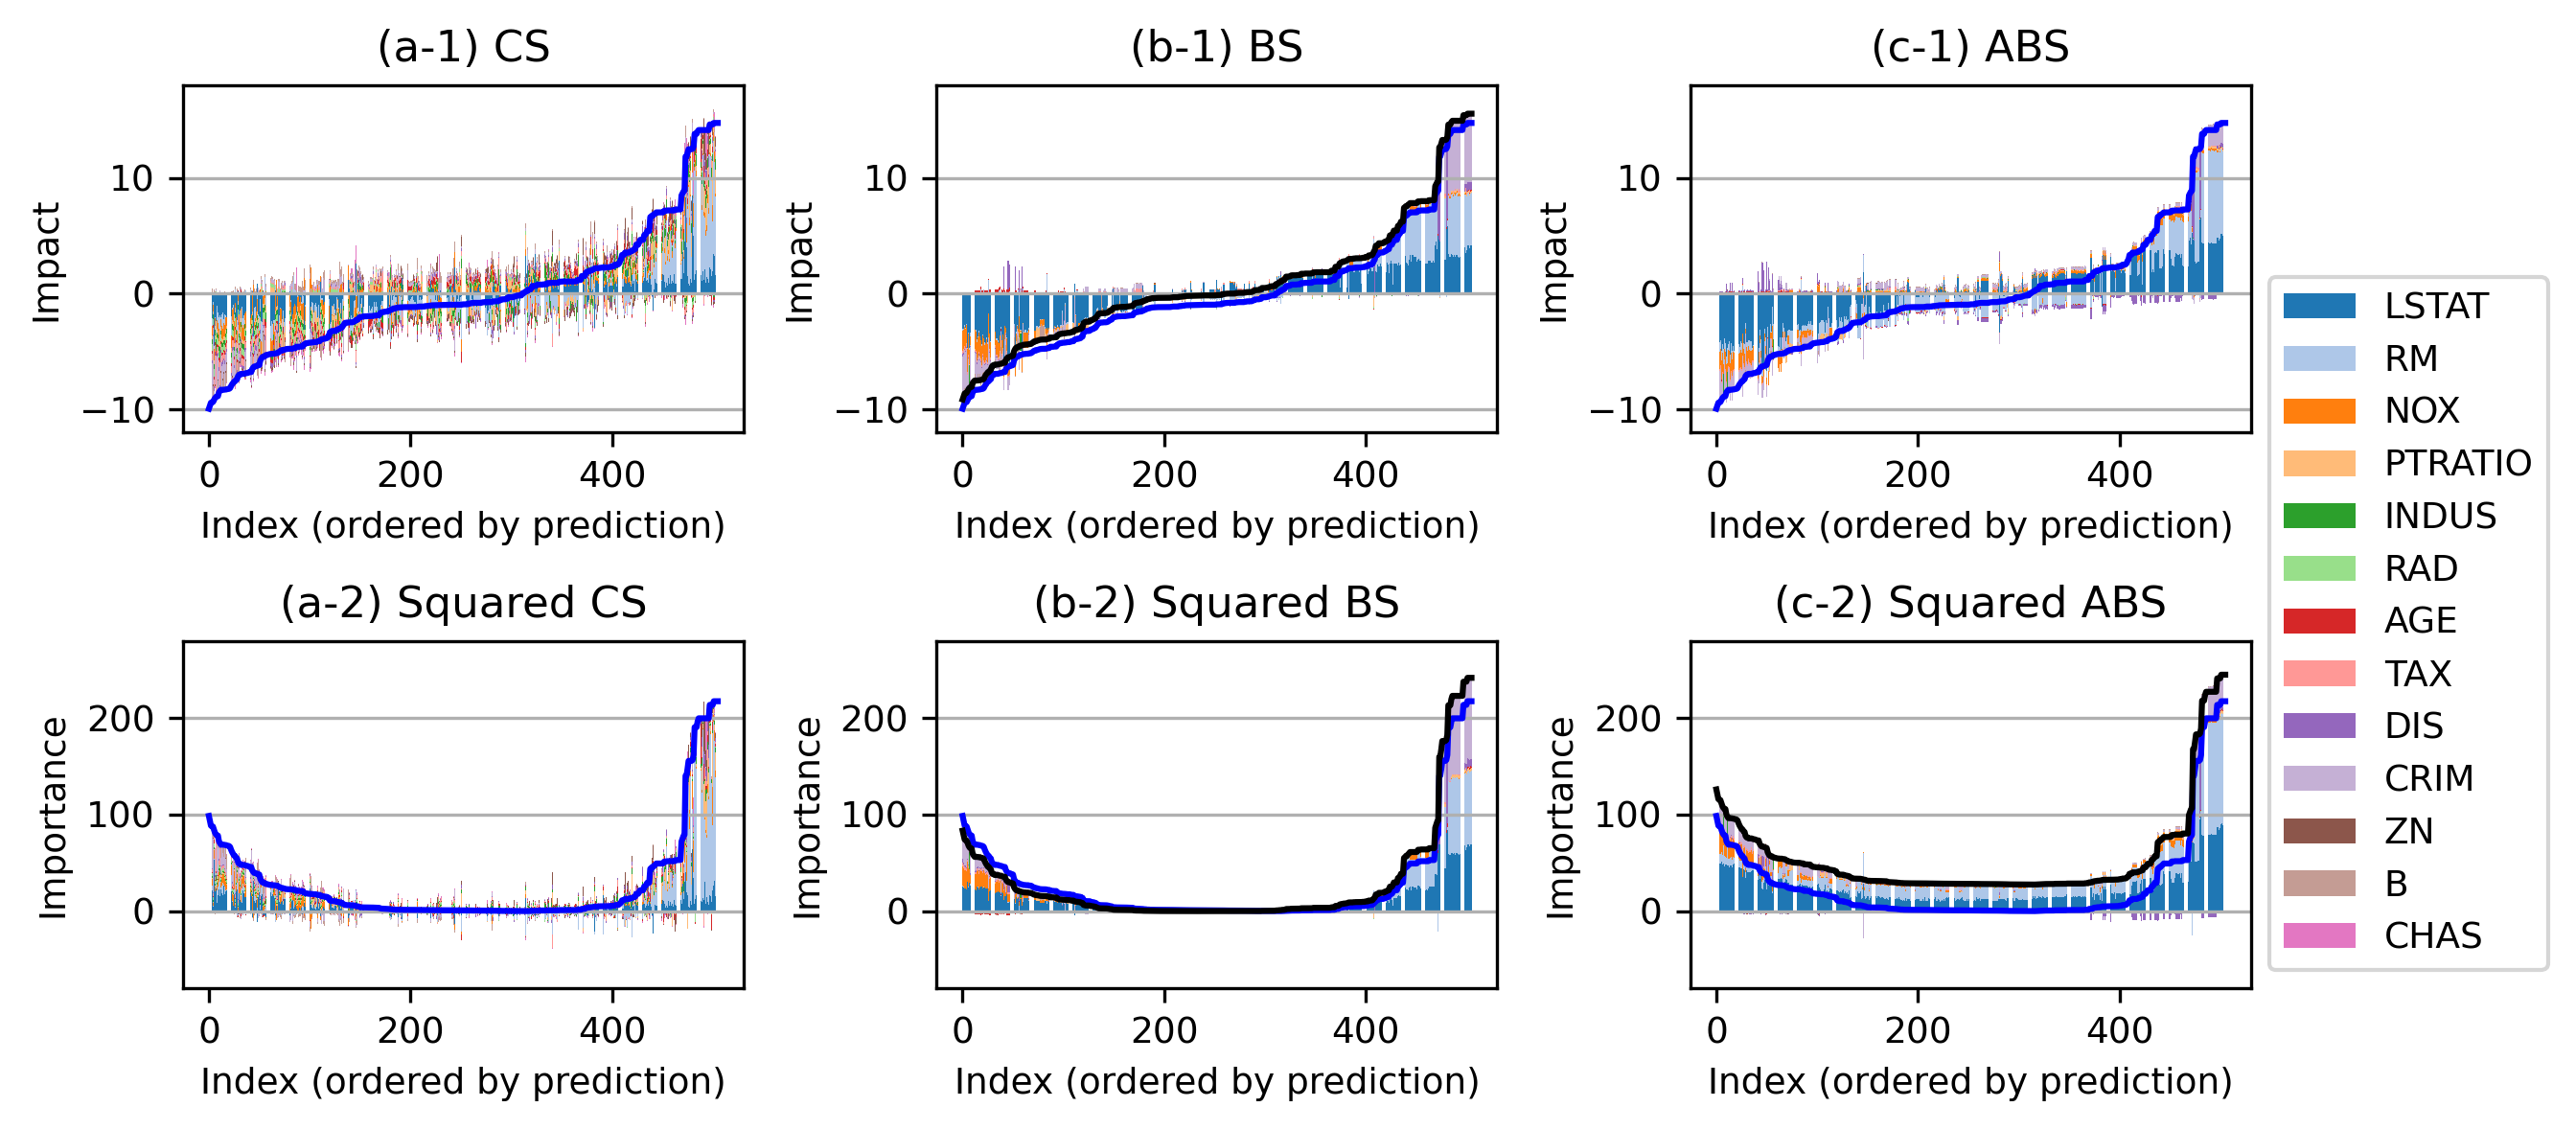

In [15]:
figure.set_color_palette('tab20')
fig = plt.figure(figsize=(8,4),dpi=300)
plt.rcParams["font.size"] = 9

plt.subplot(2,3,1)
figure.draw_aggregate_graph(cs_obja.shapley_values, X.columns, f(subject), order=order)
plt.ylim(-12,18)
plt.title('(a-1) CS')

plt.subplot(2,3,4)
figure.draw_aggregate_graph2(cs_obja.shapley_values2, X.columns, f(subject), order=order)
plt.ylim(-80,280)
plt.title('(a-2) Squared CS')

plt.subplot(2,3,2)
figure.draw_aggregate_graph(bs_obja.shapley_values, X.columns, f(subject), base=bs_obj.base_value, order=order)
plt.ylim(-12,18)
plt.title('(b-1) BS')

plt.subplot(2,3,5)
figure.draw_aggregate_graph2(bs_obja.shapley_values2, X.columns, f(subject), base=bs_obj.base_value, order=order)
plt.ylim(-80,280)
plt.title('(b-2) Squared BS')

plt.subplot(2,3,3)
figure.draw_aggregate_graph(abs_obja.shapley_values, X.columns, f(subject), order=order)
plt.ylim(-12,18)
plt.title('(c-1) ABS')

plt.subplot(2,3,6)
figure.draw_aggregate_graph2(abs_obja.shapley_values2, X.columns, f(subject), multibase=True, order=order)
plt.ylim(-80,280)
plt.title('(c-2) Squared ABS')

plt.tight_layout()
plt.legend(bbox_to_anchor=(1,0), loc='lower left')
plt.show()
figure.set_color_palette('tab10')

### Realistic/unrealistic portion in baseline and all baseline Shapley for the 205th subject

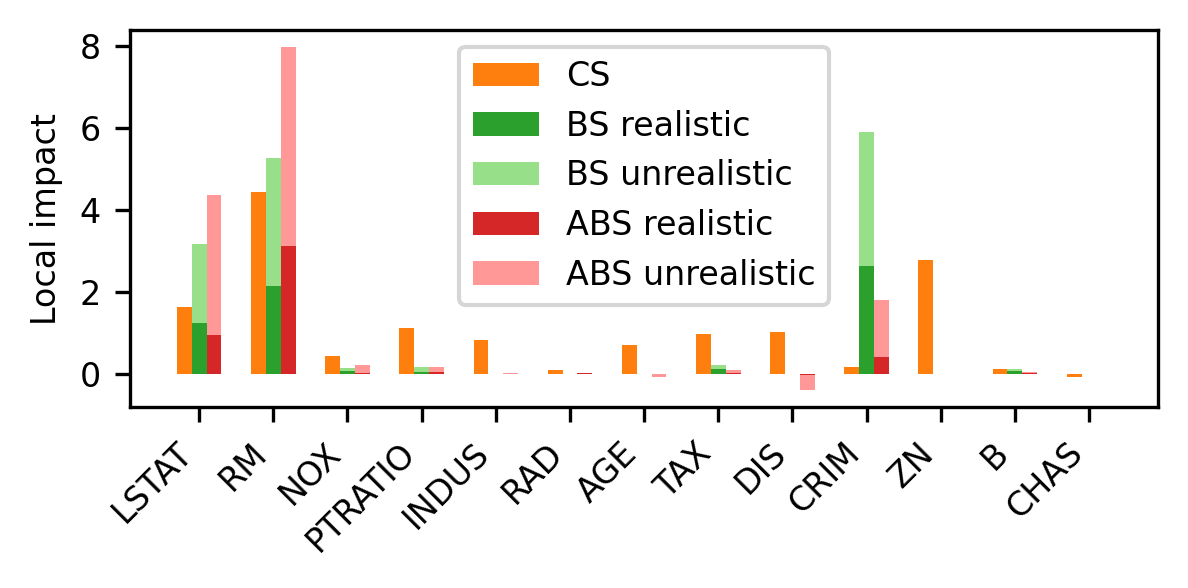

In [16]:
figure.set_color_palette('tab20')
plt.rcParams["font.size"] = 8
fig=plt.figure(figsize=(4,2),dpi=300)
plt.bar(np.arange(len(X.columns)),np.zeros(len(X.columns)),width=0)
plt.bar(np.arange(len(X.columns)),np.zeros(len(X.columns)),width=0)
plt.bar(np.arange(len(X.columns))-0.2,cs_obj.shapley_values[0][order],width=0.2,label='CS')
plt.bar(np.arange(len(X.columns)),np.zeros(len(X.columns)),width=0)
#
total = bs_obj.shapley_values[0][order]
realistic = bs_obj.shapley_values_realistic[0][order]
unrealistic = total - realistic
n_vars = len(realistic)
bar_l = np.zeros(n_vars)
bar_u = np.zeros(n_vars)
bar_l, bar_u, bottom = figure.calc_bottom(bar_l, bar_u, realistic)
plt.bar(np.arange(len(X.columns)),realistic,bottom=bottom,width=0.2,label='BS realistic')
bar_l, bar_u, bottom = figure.calc_bottom(bar_l, bar_u, unrealistic)
plt.bar(np.arange(len(X.columns)),unrealistic,bottom=bottom,width=0.2,label='BS unrealistic')
#
total = abs_obj.shapley_values[0][order]
realistic = abs_obj.shapley_values_realistic[0][order]
unrealistic = total - realistic
n_vars = len(realistic)
bar_l = np.zeros(n_vars)
bar_u = np.zeros(n_vars)
bar_l, bar_u, bottom = figure.calc_bottom(bar_l, bar_u, realistic)
plt.bar(np.arange(len(X.columns))+0.2,realistic,bottom=bottom,width=0.2,label='ABS realistic')
bar_l, bar_u, bottom = figure.calc_bottom(bar_l, bar_u, unrealistic)
plt.bar(np.arange(len(X.columns))+0.2,unrealistic,bottom=bottom,width=0.2, label='ABS unrealistic')
#
plt.bar(np.arange(len(X.columns)),np.zeros(len(X.columns)),width=0,tick_label=X.columns[order])
plt.ylabel('Local impact')
fig.autofmt_xdate(rotation=45)
plt.legend()
plt.tight_layout()
figure.set_color_palette('tab10')

### Comparison of global explanation by squared versions

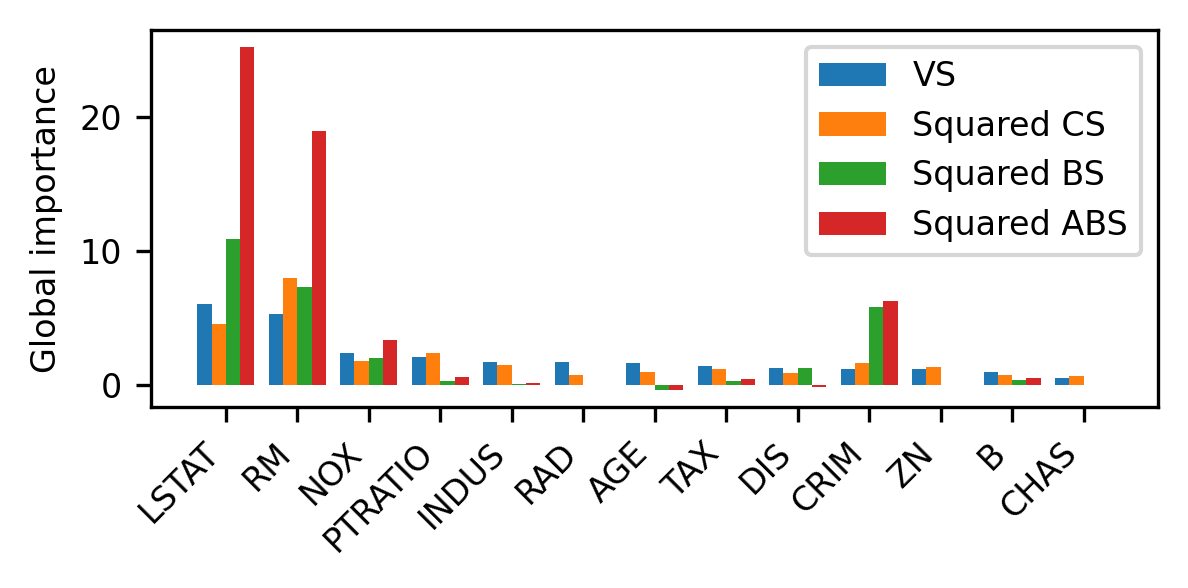

In [17]:
fig=plt.figure(figsize=(4,2),dpi=300)
plt.bar(np.arange(len(X.columns))-0.3,vs_values[order],width=0.2,label='VS')
plt.bar(np.arange(len(X.columns))-0.1,cs_obja.shapley_values2.mean(axis=0)[order],width=0.2,label='Squared CS')
plt.bar(np.arange(len(X.columns))+0.1,bs_obja.shapley_values2.mean(axis=0)[order],width=0.2,label='Squared BS')
plt.bar(np.arange(len(X.columns))+0.3,abs_obja.shapley_values2.mean(axis=0)[order],width=0.2,label='Squared ABS')
plt.bar(np.arange(len(X.columns)),np.zeros(len(X.columns)),width=0,tick_label=X.columns[order])
plt.ylabel('Global importance')
fig.autofmt_xdate(rotation=45)
plt.legend()
plt.tight_layout()